In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# be careful with that:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data

data_heatmap = pd.read_csv('../datasets/A_data_heatmap_300x250_3p.csv')
data_metrics = pd.read_csv('../datasets/A_data_domain_perf_metrics_300x250_3p.csv')

In [29]:
data_metrics

,Unnamed: 0,domain,grid_id,webview_height,webview_width,displays,clicks,landed_clicks,non_bounced_clicks,closing_events,avg_last_second_framerate,sov_short_ttc,sov_short_ttc_global,sov_short_ttc_score
0,0,ID_1815,333519,250.0,300.0,2832,11.0,6.0,3.0,7.0,60.578947,0.002750,0.049334,-0.046584
1,1,ID_979,333519,250.0,300.0,2169,1.0,1.0,1.0,NaN,59.000000,NaN,NaN,NaN
2,2,ID_1413,333519,250.0,300.0,7077,16.0,2.0,0.0,5.0,31.333333,0.345627,0.185044,0.292426
3,3,ID_1408,333519,250.0,300.0,14106,22.0,17.0,2.0,NaN,56.500000,NaN,NaN,NaN
4,4,ID_1196,333519,250.0,300.0,2688,1.0,1.0,1.0,NaN,55.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5501,5501,ID_2786,333346,250.0,300.0,5691,6.0,6.0,5.0,3.0,60.583333,NaN,NaN,NaN
5502,5502,ID_2974,333346,250.0,300.0,152352,27.0,23.0,9.0,NaN,71.489362,0.012835,0.049334,-0.036499
5503,5503,ID_385,333346,250.0,300.0,96687,42.0,33.0,12.0,1.0,66.844444,0.010152,0.053200,-0.039182
5504,5504,ID_3557,333346,250.0,300.0,1011320,475.0,405.0,263.0,48.0,73.767480,0.069024,0.053200,0.019690


In [3]:
# expand so that each row corresponds to 1 click:

data_heatmap_expanded = data_heatmap.loc[data_heatmap.index.repeat(data_heatmap['clicks'])].reset_index(drop=True)
data_heatmap_expanded['clicks'] = 1

click_stat = data_heatmap_expanded.groupby(['click_x','click_y'])['clicks'].count().reset_index()

In [4]:
data_heatmap

,Unnamed: 0,domain,grid_id,click_x,click_y,display_height,display_width,clicks
0,0,ID_1763,333519,179,4,250,300,1
1,1,ID_1763,333519,262,185,250,300,1
2,2,ID_1763,333519,122,188,250,300,1
3,3,ID_1763,333519,263,197,250,300,1
4,4,ID_1763,333519,242,159,250,300,1
...,...,...,...,...,...,...,...,...
1935421,1935421,ID_1501,333519,163,145,250,300,8
1935422,1935422,ID_1501,333519,41,139,250,300,4
1935423,1935423,ID_1501,333519,213,97,250,300,2
1935424,1935424,ID_1501,333519,271,245,250,300,1


In [5]:
# Binning clicks in nr_of_x_bins, nr_of_y_bins:

NR_OF_X_BINS = 61
NR_OF_Y_BINS = 51

max_width = data_heatmap['display_width'].max()
max_height = data_heatmap['display_height'].max()

width_bins = np.linspace(1, max_width, NR_OF_X_BINS)
height_bins = np.linspace(1, max_height, NR_OF_Y_BINS)

width_bins_max = len(width_bins)-2 # start at 0
height_bins_max = len(height_bins)-2

data_heatmap_expanded['click_x_bin'] = pd.cut(data_heatmap_expanded['click_x'], 
                                      bins = width_bins, 
                                      labels=False, 
                                      include_lowest=True)

data_heatmap_expanded['click_y_bin'] = pd.cut(data_heatmap_expanded['click_y'], 
                                      bins=height_bins, 
                                      labels=False, 
                                      include_lowest=True)


aggregated_clicks = data_heatmap_expanded.groupby(['grid_id',
                                           'domain', 
                                           'click_x_bin', 
                                           'click_y_bin']).size().reset_index(name='clicks_sum')


#aggregated_clicks['clicks_sum'].astype('int64');

In [6]:
# add empty bins --> easier to generate vectors
# takes a few seconds

from itertools import product

domains_grids = data_heatmap[['domain', 'grid_id']].drop_duplicates()

aux = pd.DataFrame(list(product(range(0,width_bins_max+1), 
                                range(0,height_bins_max+1))), 
                   columns=['click_x_bin', 'click_y_bin'])

domains_grids['key'] = 1
aux['key'] = 1

expanded_set = pd.merge(domains_grids, aux, on='key').drop('key', axis=1)

data_binned = pd.merge(expanded_set, aggregated_clicks, 
                  on = ['domain', 'grid_id', 'click_x_bin', 'click_y_bin'], 
                  how = 'left').fillna(0)
data_binned['clicks_sum'] = data_binned['clicks_sum'].astype('int64')
data_binned

,domain,grid_id,click_x_bin,click_y_bin,clicks_sum
0,ID_1763,333519,0,0,0
1,ID_1763,333519,0,1,0
2,ID_1763,333519,0,2,0
3,ID_1763,333519,0,3,0
4,ID_1763,333519,0,4,0
...,...,...,...,...,...
5198995,ID_1382,333346,59,45,0
5198996,ID_1382,333346,59,46,0
5198997,ID_1382,333346,59,47,0
5198998,ID_1382,333346,59,48,0


In [28]:
# for clustering

data_binned[(data_binned.domain == 'ID_1763') &
            (data_binned.grid_id == 333519)]['clicks_sum'].to_numpy()

array([0, 0, 0, ..., 0, 0, 0])

In [7]:
cl_stat = aggregated_clicks.groupby(['click_x_bin','click_y_bin']).count().reset_index()
cl_stat = cl_stat[['click_x_bin','click_y_bin','clicks_sum']]
cl_stat['bin_prob'] = cl_stat['clicks_sum']/cl_stat['clicks_sum'].sum()

In [8]:
# aggregated clicks by grid_id:

aggregated_clicks_by_grid = aggregated_clicks.groupby([
                                'grid_id','click_x_bin','click_y_bin'
                            ]).sum('clicks_sum').reset_index()

------

# Some visualization

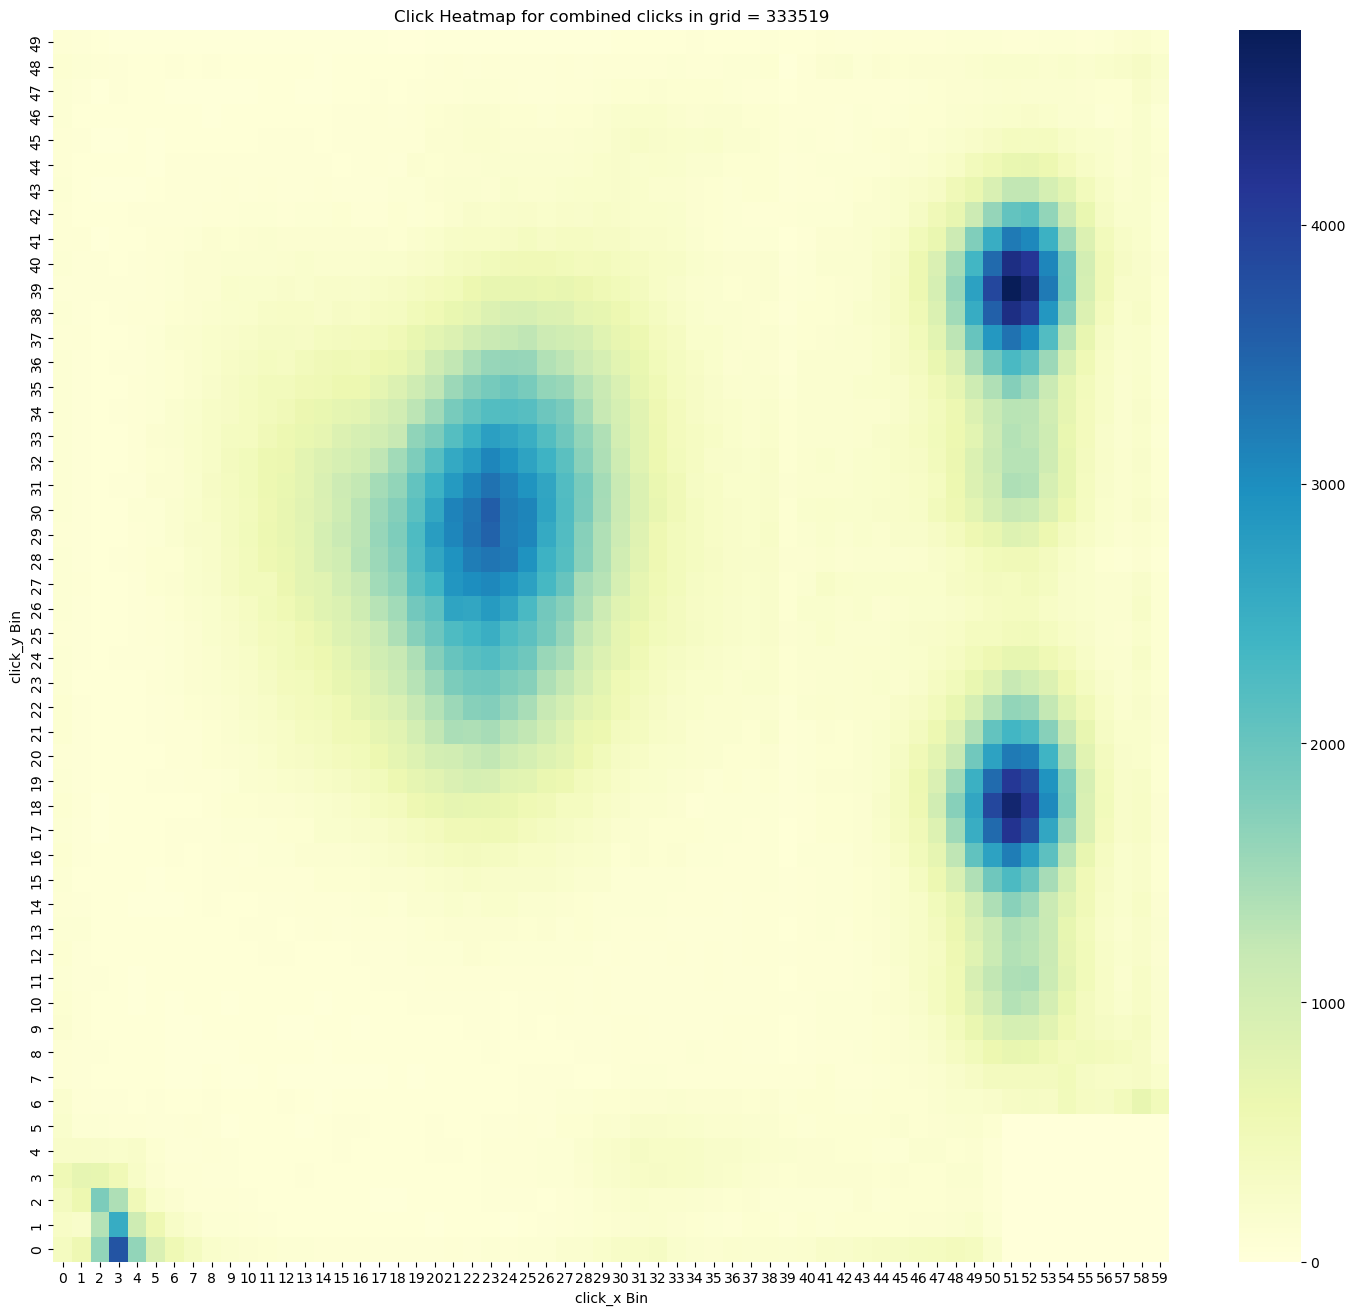

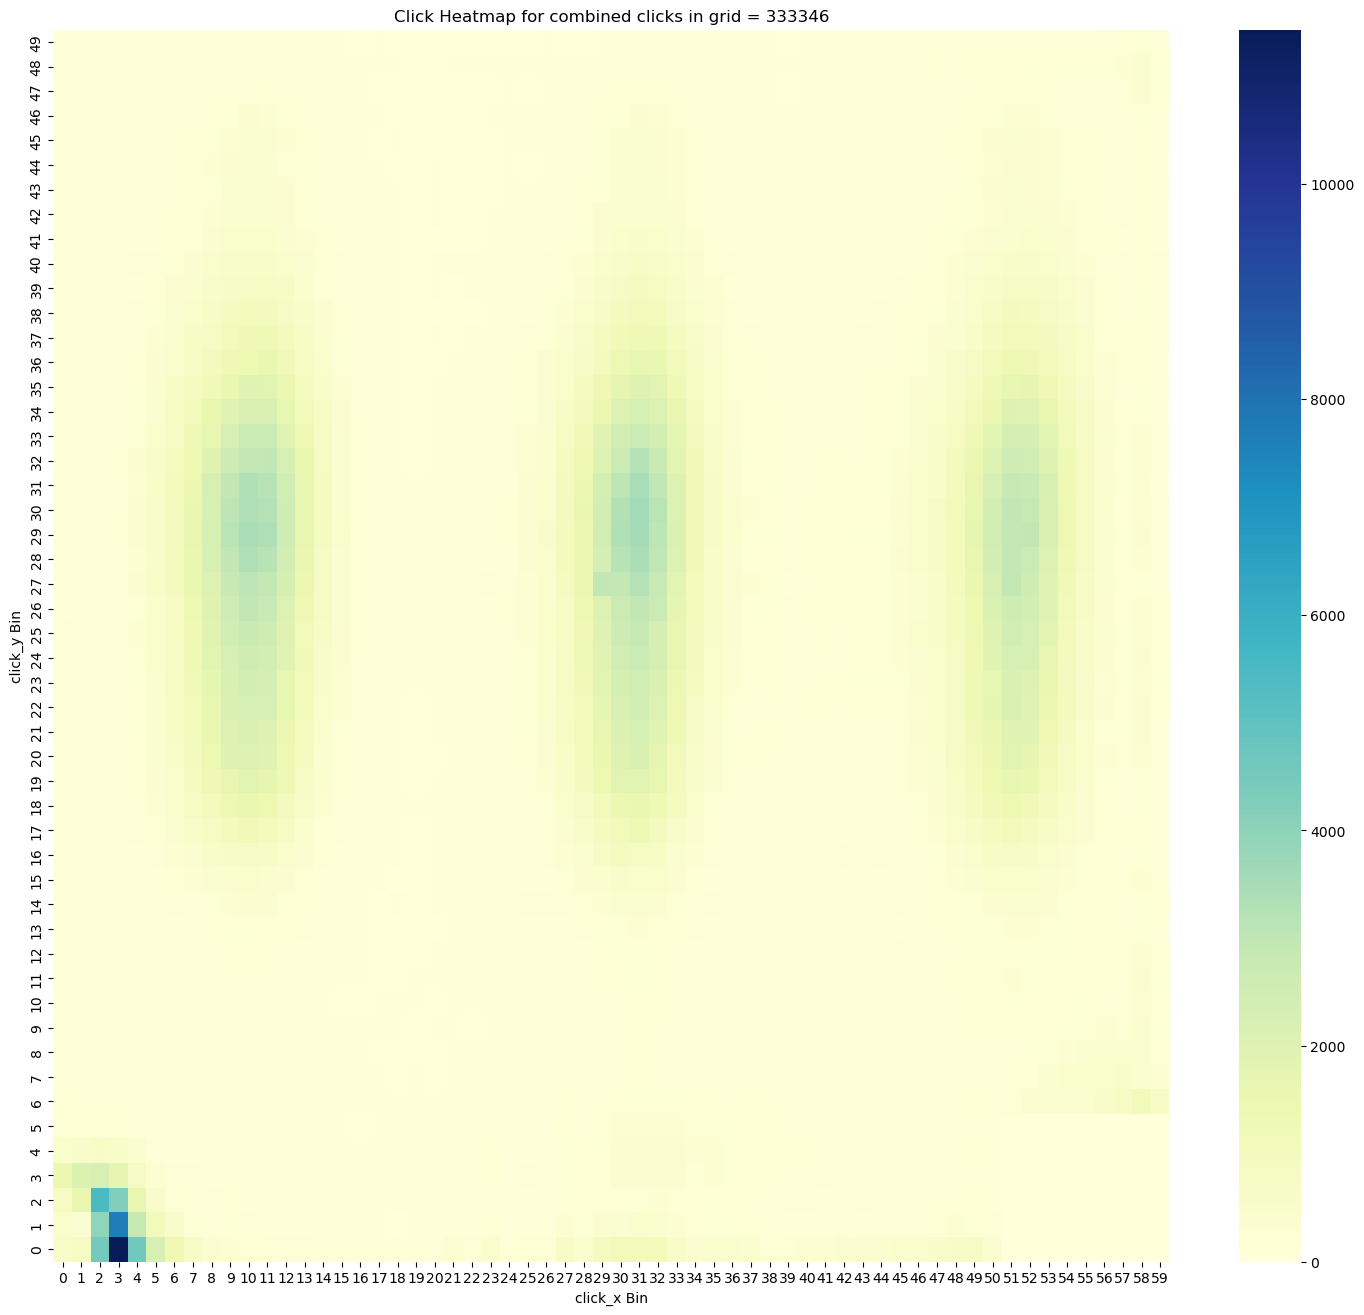

In [9]:
# create aggregated heatmaps:

ex = aggregated_clicks_by_grid[aggregated_clicks_by_grid.grid_id == 333519]

click_matrix = ex.pivot("click_y_bin","click_x_bin", "clicks_sum").fillna(0)

plt.figure(figsize=(18, 16))
sns.heatmap(click_matrix, 
            cmap = "YlGnBu", 
            annot = False, 
            cbar = True, 
            fmt = "g")

plt.title(f'Click Heatmap for combined clicks in grid = {333519}')
plt.xlabel('click_x Bin')
plt.ylabel('click_y Bin')
plt.gca().invert_yaxis() 
#plt.savefig('hm_333519.png', bbox_inches='tight')
plt.show()

ex = aggregated_clicks_by_grid[aggregated_clicks_by_grid.grid_id == 333346]

click_matrix = ex.pivot("click_y_bin","click_x_bin", "clicks_sum").fillna(0)

plt.figure(figsize=(18, 16))
sns.heatmap(click_matrix, 
            cmap = "YlGnBu", 
            annot = False, 
            cbar = True, 
            fmt = "g")

plt.title(f'Click Heatmap for combined clicks in grid = {333346}')
plt.xlabel('click_x Bin')
plt.ylabel('click_y Bin')
plt.gca().invert_yaxis() 
#plt.savefig('hm_333519.png', bbox_inches='tight')
plt.show()

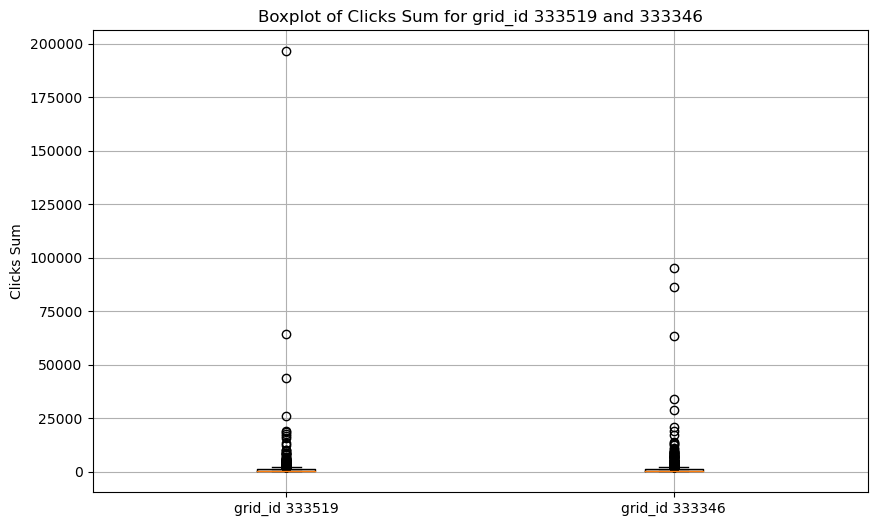

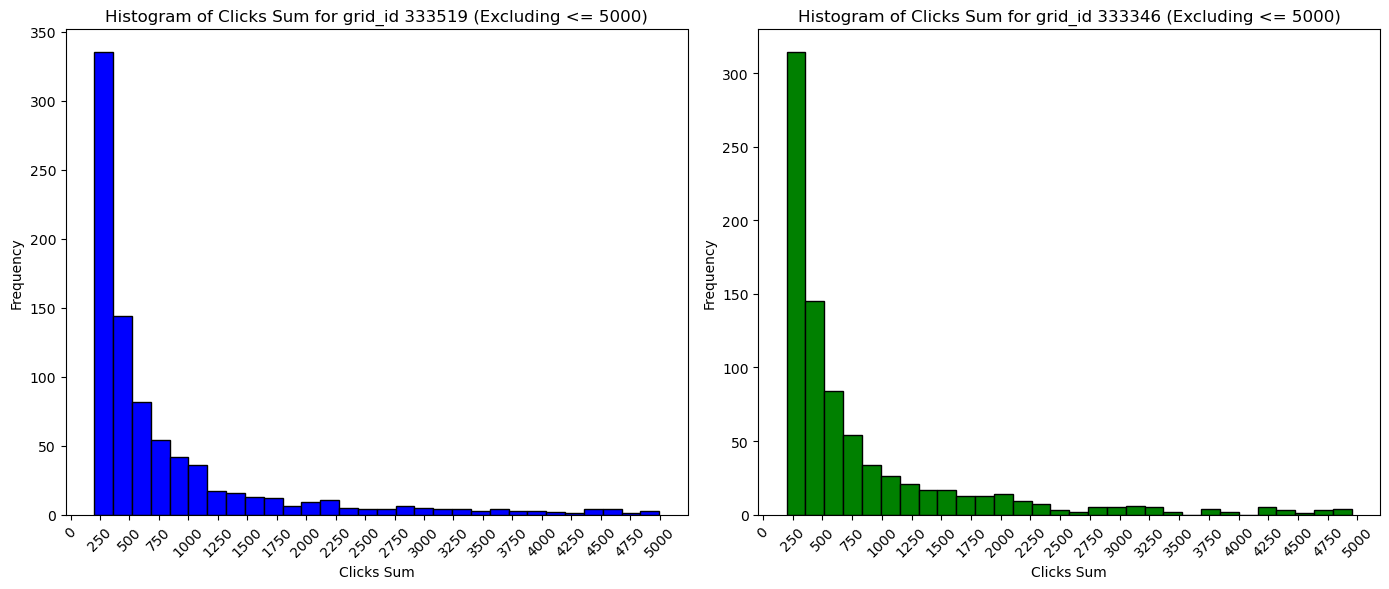

Nr of domains with grid_id 333346 and more than 1k clicks: 227
Percentage of domains with grid_id 333346 and more than 1k clicks: 0.26
Nr of domains with grid_id 333519 and more than 1k clicks: 215
Percentage of domains with grid_id 333519 and more than 1k clicks: 0.25


In [10]:
# Boxplots and histograms

x = aggregated_clicks.groupby(['domain','grid_id']).sum().reset_index()

data_333519 = x[x.grid_id == 333519]['clicks_sum']
data_333346 = x[x.grid_id == 333346]['clicks_sum']

plt.figure(figsize=(10, 6))
plt.boxplot([data_333519, data_333346], labels=['grid_id 333519', 'grid_id 333346'])
plt.title('Boxplot of Clicks Sum for grid_id 333519 and 333346')
plt.ylabel('Clicks Sum')
plt.grid(True)
#plt.savefig('bp.png', bbox_inches='tight')
plt.show()

data_333519 = x[(x.grid_id == 333519) & (x.clicks_sum <= 5000)]['clicks_sum']
data_333346 = x[(x.grid_id == 333346) & (x.clicks_sum <= 5000)]['clicks_sum']

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(data_333519, bins=30, color='blue', edgecolor='black')
plt.title('Histogram of Clicks Sum for grid_id 333519 (Excluding <= 5000)')
plt.xlabel('Clicks Sum')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  
plt.ticklabel_format(style='plain', axis='x') 
plt.locator_params(axis='x', nbins=24)  

plt.subplot(1, 2, 2)
plt.hist(data_333346, bins=30, color='green', edgecolor='black')
plt.title('Histogram of Clicks Sum for grid_id 333346 (Excluding <= 5000)')
plt.xlabel('Clicks Sum')
plt.ylabel('Frequency')
plt.xticks(rotation=45) 
plt.ticklabel_format(style='plain', axis='x')  
plt.locator_params(axis='x', nbins=24) 

plt.tight_layout()

#plt.savefig('histo.png', bbox_inches='tight')
plt.show()

g_333346_nr_ge1000 = len(x[(x.grid_id == 333346) & (x.clicks_sum > 1000)]['domain'].unique())
pct_333346_nr_ge1000 = g_333346_nr_ge1000/len(x[(x.grid_id == 333346)]['domain'].unique())
print(f'Nr of domains with grid_id {333346} and more than 1k clicks: {g_333346_nr_ge1000}')
print(f'Percentage of domains with grid_id {333346} and more than 1k clicks: {pct_333346_nr_ge1000:.2f}')

g_333519_nr_ge1000 = len(x[(x.grid_id == 333519) & (x.clicks_sum > 1000)]['domain'].unique())
pct_333519_nr_ge1000 = g_333519_nr_ge1000/len(x[(x.grid_id == 333519)]['domain'].unique())
print(f'Nr of domains with grid_id {333519} and more than 1k clicks: {g_333519_nr_ge1000}')
print(f'Percentage of domains with grid_id {333519} and more than 1k clicks: {pct_333519_nr_ge1000:.2f}')

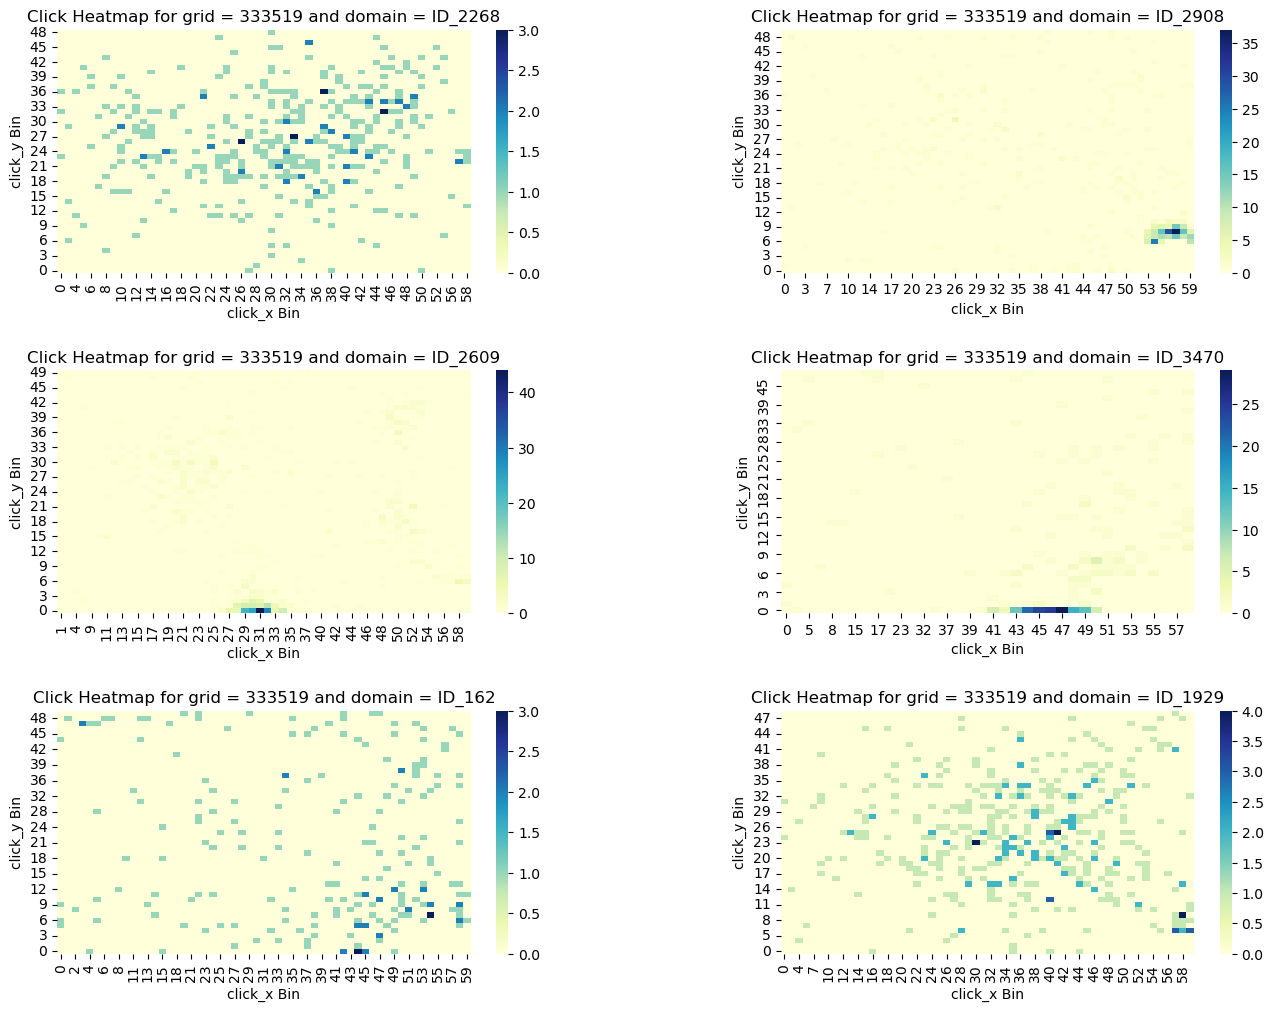

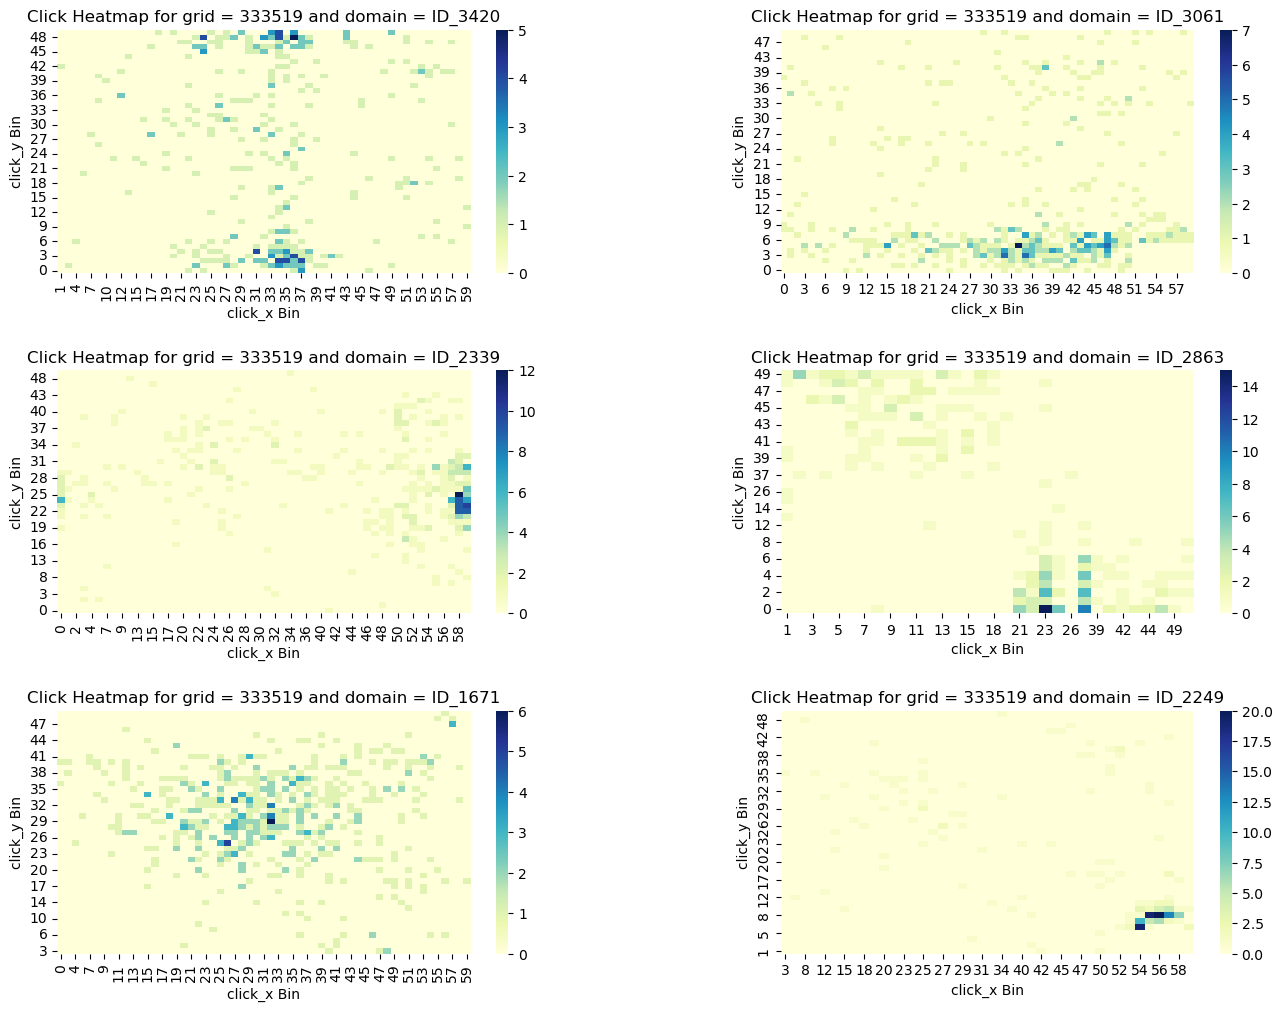

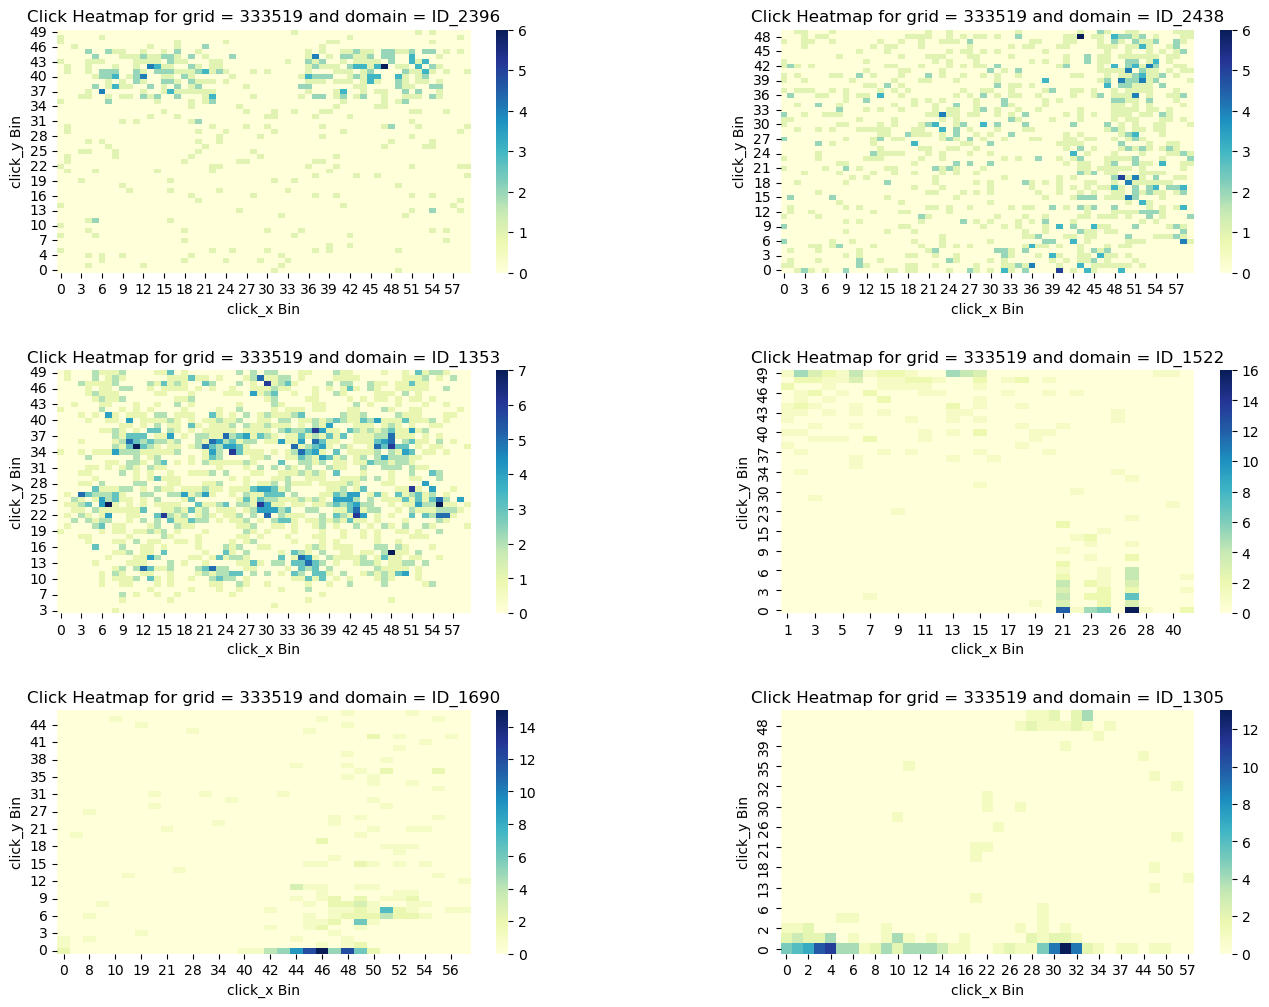

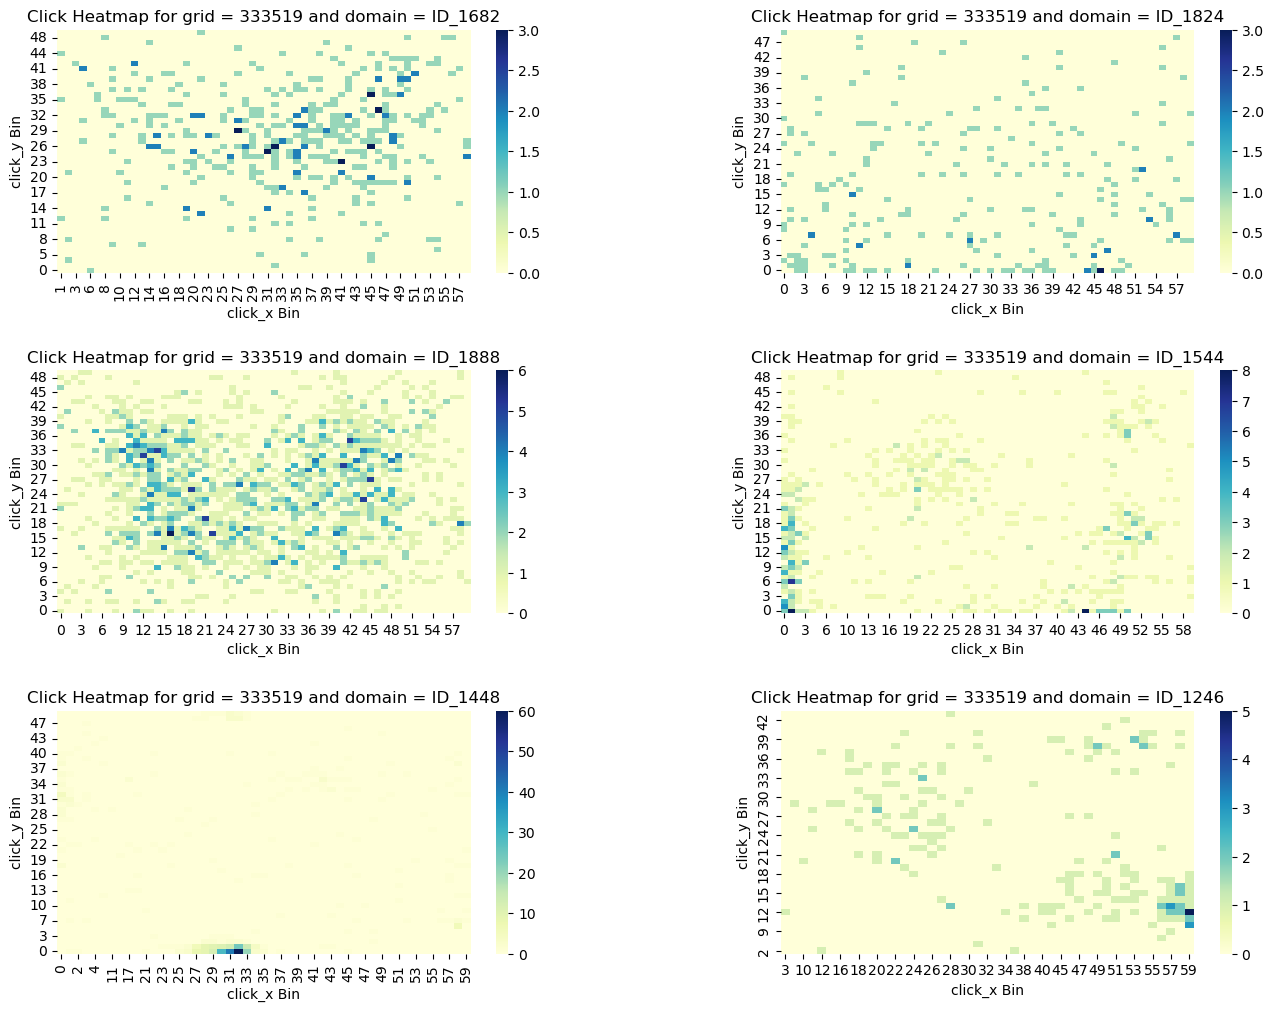

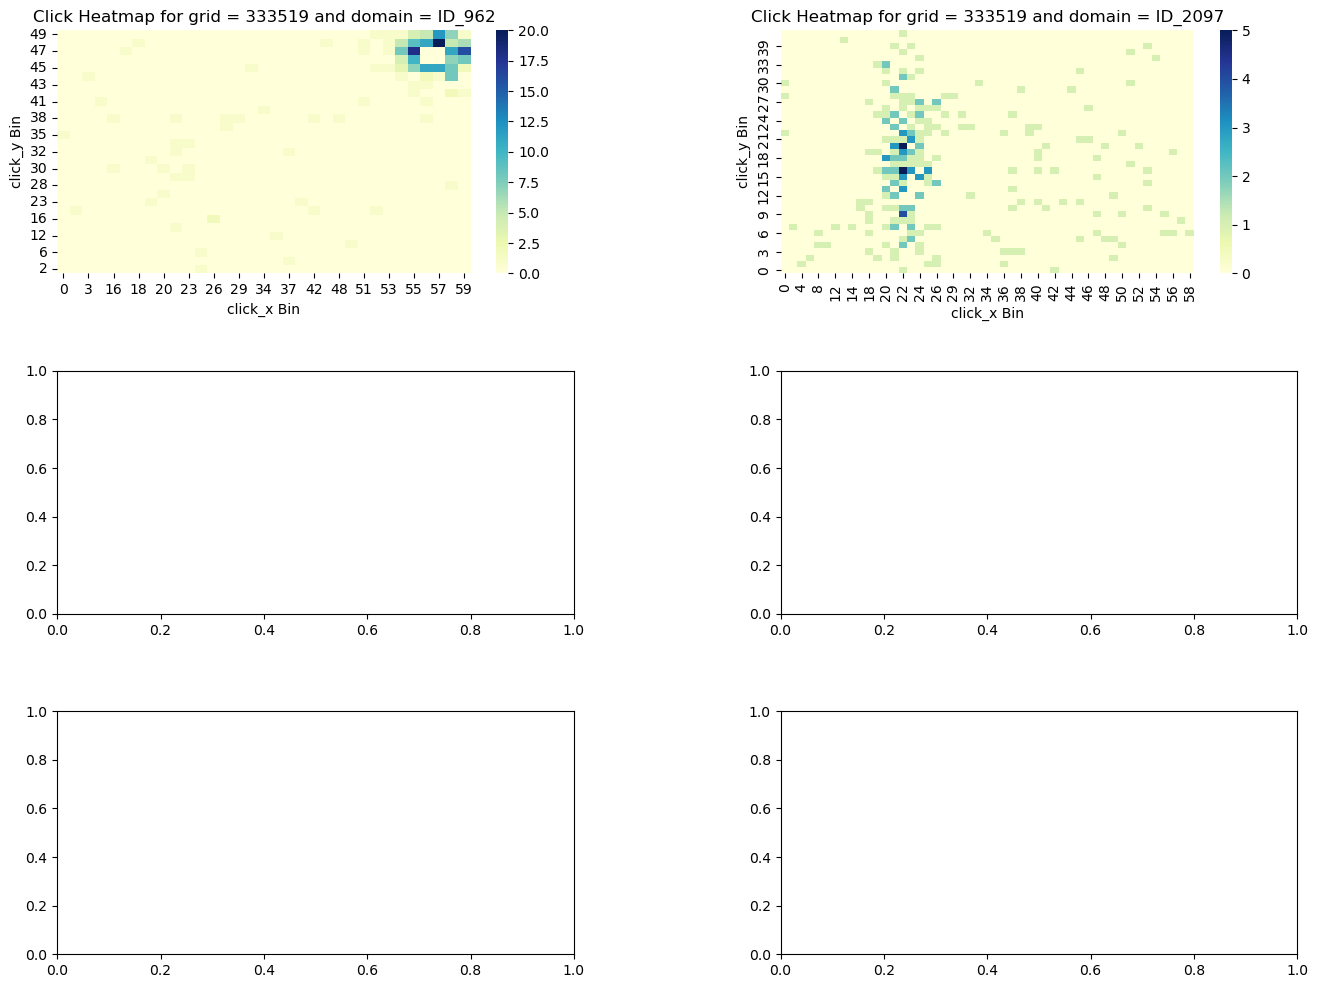

In [11]:
# example of broken banners (pretty sure) for grid_id = 333519:

some_broken = {'ID_1246', 'ID_1305', 'ID_1353', 'ID_1448', 'ID_1522', 'ID_1544', 
               'ID_162',  'ID_1671', 'ID_1682', 'ID_1690', 'ID_1824', 'ID_1888', 'ID_1929', 
               'ID_2097', 'ID_2249', 'ID_2268', 'ID_2339', 'ID_2396', 'ID_2438', 
               'ID_2609', 'ID_2863', 'ID_2908', 'ID_3061', 'ID_3420', 'ID_3470', 'ID_962'}

some_broken_list = list(some_broken)

n_rows, n_cols = 3, 2  # 3x2 layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))  # Adjust the figure size as needed
fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing between plots

plot_count = 0
total_plots = len(some_broken_list)

for idx, br in enumerate(some_broken_list):
    GRID_ID = 333519
    ID = br
#    print(br)
    ex = aggregated_clicks[(aggregated_clicks.grid_id == GRID_ID) &
                           (aggregated_clicks.domain == ID)]

    click_matrix = ex.pivot("click_y_bin", "click_x_bin", "clicks_sum").fillna(0)
    
    if plot_count == n_rows * n_cols:  # Check if the figure is full
        #plt.savefig(f'heatmap_combined_{idx}.png', bbox_inches='tight')  # Save current figure
        plt.show()
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))  # Start a new figure
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        plot_count = 0  # Reset plot count for the new figure

    row = plot_count // n_cols
    col = plot_count % n_cols
    
    ax = axes[row, col]
    sns.heatmap(click_matrix, 
                cmap="YlGnBu", 
                annot=False, 
                cbar=True, 
                fmt="g", 
                ax=ax)
    ax.set_title(f'Click Heatmap for grid = {GRID_ID} and domain = {ID}')
    ax.set_xlabel('click_x Bin')
    ax.set_ylabel('click_y Bin')
    ax.invert_yaxis()
    
    plot_count += 1

if plot_count > 0:
#    plt.savefig(f'heatmap_combined_final.png', bbox_inches='tight')
    plt.show()



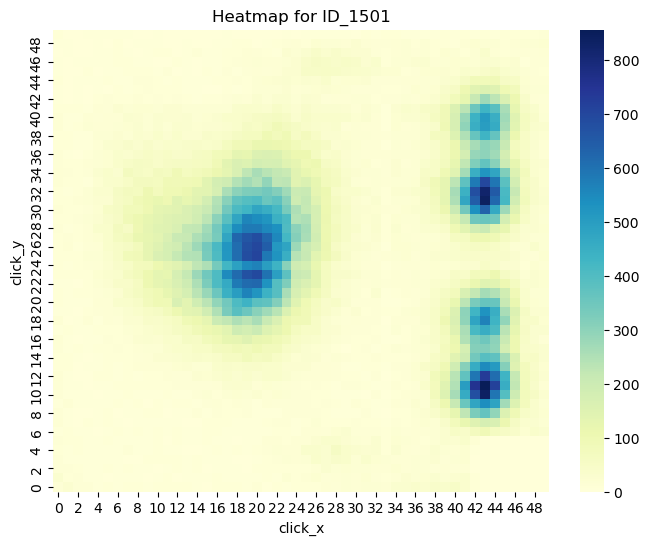

In [12]:
x = data_heatmap_expanded[(data_heatmap_expanded.grid_id == 333519) & 
                          (data_heatmap_expanded.domain == 'ID_1501')]
heatmap_data, xedges, yedges = np.histogram2d(x['click_x'], x['click_y'], 
                                              bins=[50, 50])

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data.T, cmap='YlGnBu', cbar=True)
plt.title(f'Heatmap for ID_1501')
plt.xlabel('click_x')
plt.ylabel('click_y')
plt.gca().invert_yaxis() # Invert y-axis to match the coordinate system
plt.show()

Total number of clicks for domain = ID_1 and grid = 333346: 550


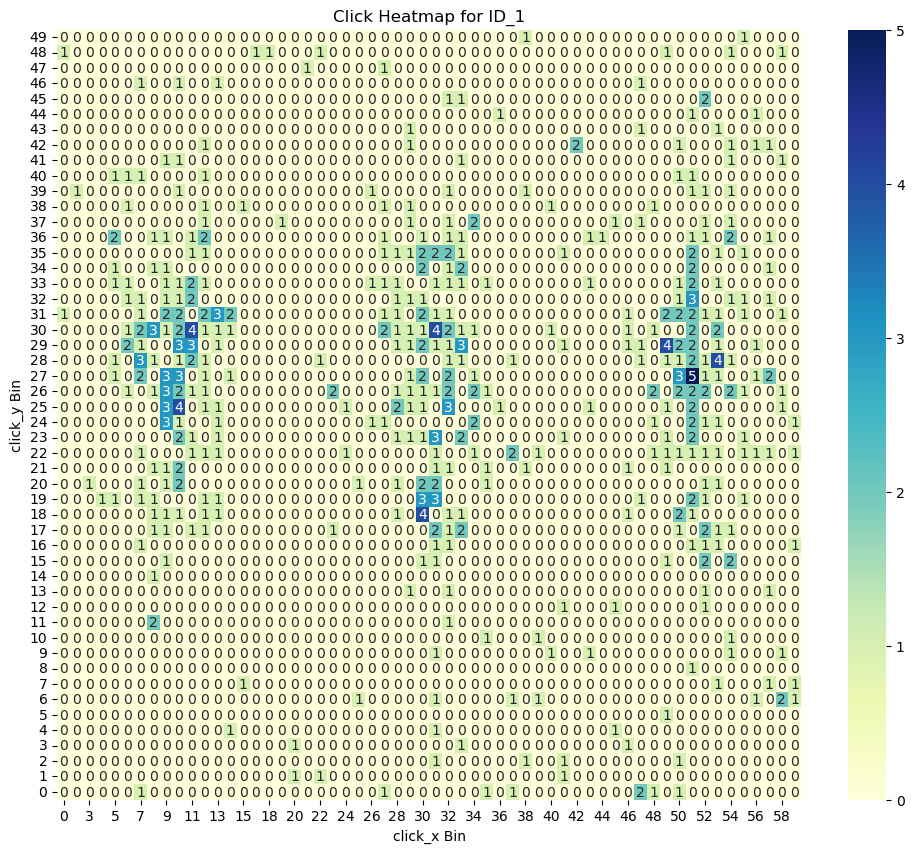

Total number of clicks for domain = ID_10 and grid = 333346: 2257


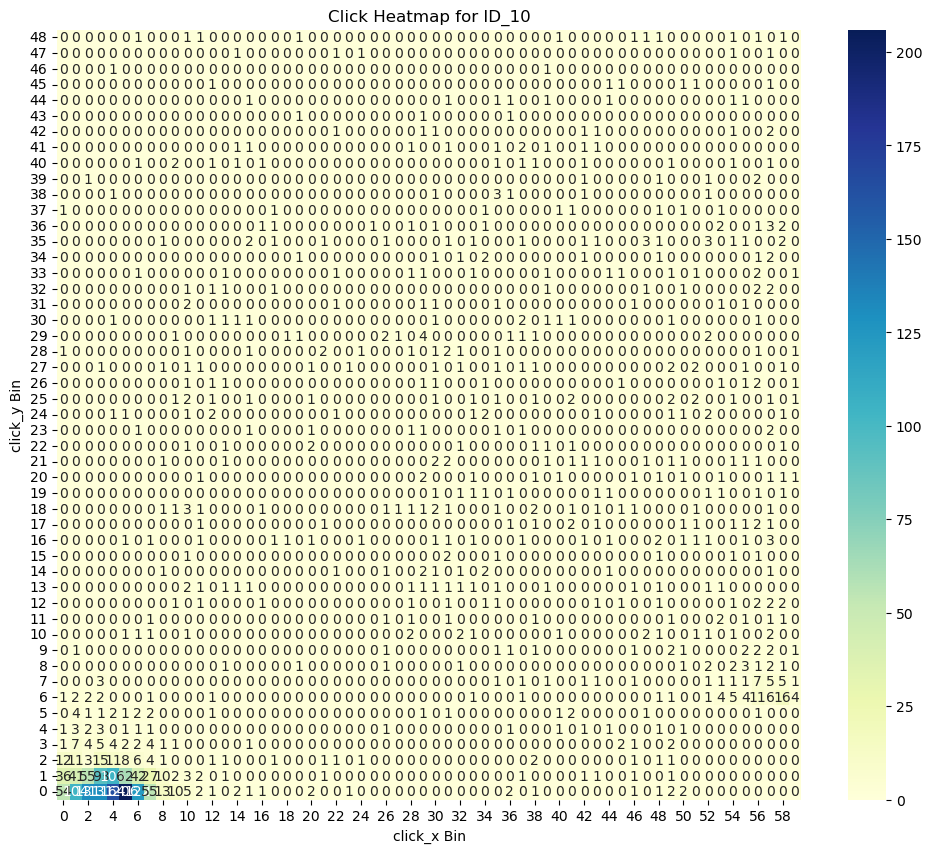

Total number of clicks for domain = ID_1002 and grid = 333346: 577


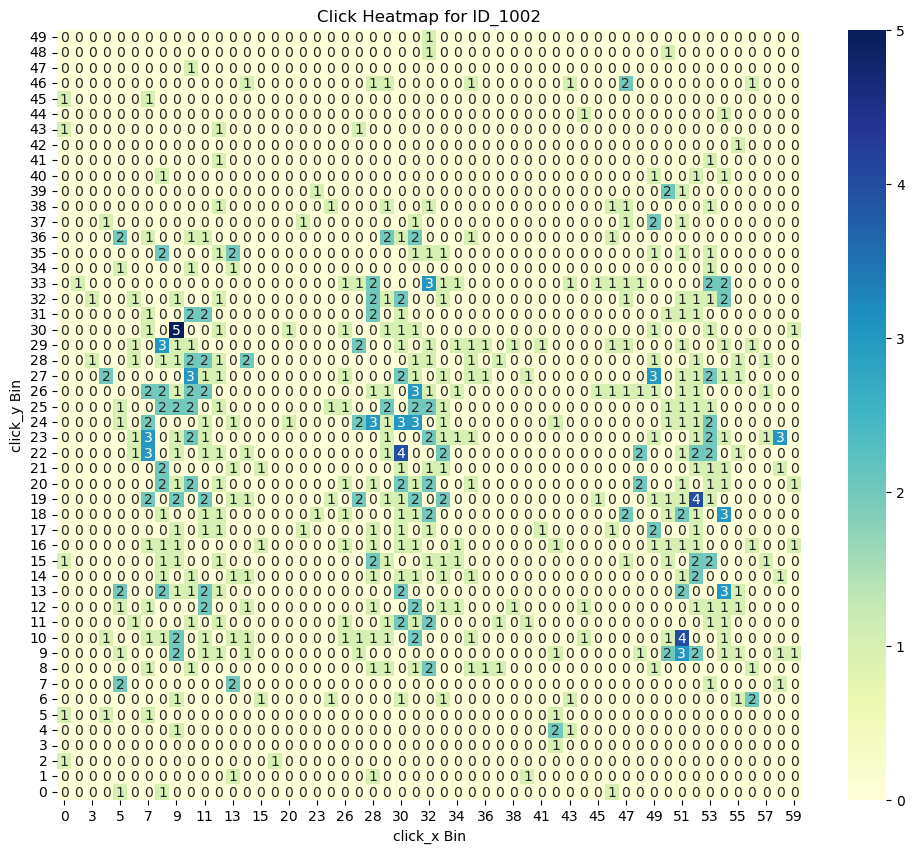

In [13]:
unique_domains = aggregated_clicks['domain'].unique()

for domain in unique_domains[:3]:
    domain_data = aggregated_clicks[(aggregated_clicks.grid_id == 333346) & 
                                    (aggregated_clicks['domain'] == domain)]
    
    click_matrix = domain_data.pivot("click_y_bin", "click_x_bin", "clicks_sum").fillna(0)
    tot_clicks = domain_data['clicks_sum'].sum()
    print(f'Total number of clicks for domain = {domain} and grid = {333346}: {tot_clicks}')
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(click_matrix, cmap="YlGnBu", annot=True, cbar=True, fmt="g")
    plt.title(f'Click Heatmap for {domain}')
    plt.xlabel('click_x Bin')
    plt.ylabel('click_y Bin')
    plt.gca().invert_yaxis()  # Adjust to match the coordinate system orientation if necessary
    plt.show()

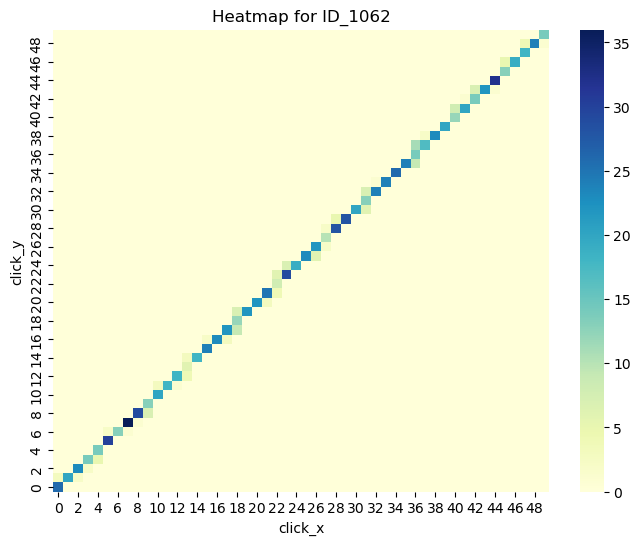

In [14]:
data_heatmap_expanded = data_heatmap.loc[
                                         data_heatmap.index.repeat(data_heatmap['clicks'])
                                        ].reset_index(drop=True)

x = data_heatmap_expanded[(data_heatmap_expanded.grid_id == 333346) & 
                          (data_heatmap_expanded.domain == 'ID_1062')]

heatmap_data, xedges, yedges = np.histogram2d(x['click_x'], x['click_y'], 
                                              bins=[50, 50])

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data.T, cmap='YlGnBu', cbar=True)
plt.title(f'Heatmap for ID_1062')
plt.xlabel('click_x')
plt.ylabel('click_y')
plt.gca().invert_yaxis() 
plt.show()

# Some Bootstrap functions

In [15]:
# def weighted_bootstrap_resample(data, weights, n_bootstraps=1000):
#     boot_means = []
#     for _ in range(n_bootstraps):
#         indices = np.random.choice(data.index, 
#                                    size=len(data), 
#                                    replace=True, 
#                                    p=weights)
#         boot_sample = data.loc[indices]
#         boot_means.append(np.mean(boot_sample['clicks_sum']))
#     return np.mean(boot_means), np.percentile(boot_means, [2.5, 97.5])

def weighted_bootstrap_resample(data, drawing_distro, emp_distro, size, n_bootstraps=1000):
    tot_log_proba = 0
    for _ in range(n_bootstraps):
        indices = np.random.choice(data.index, 
                                   size=size, 
                                   replace=True, 
                                   p=data[drawing_distro])
        log_proba = np.log(data.loc[indices][emp_distro]).sum()
        tot_log_proba += log_proba
    return tot_log_proba/n_bootstraps #boots[['click_x_bin','click_y_bin', 'boot']]

## Chi-Squared:

In [16]:
from scipy.stats import chisquare

def Chi_squared_test(aggregated_clicks, aggregated_clicks_by_grid, ID, GRID_ID):
    observed = aggregated_clicks[(aggregated_clicks.grid_id == GRID_ID) &
                                 (aggregated_clicks.domain == ID)]

    click_stat_grid = aggregated_clicks_by_grid[aggregated_clicks_by_grid.grid_id == GRID_ID]
    click_stat_grid = click_stat_grid.copy()
    click_stat_grid['bin_prob'] = click_stat_grid['clicks_sum']/click_stat_grid['clicks_sum'].sum()

    observed_freq = observed.merge(click_stat_grid, 
                                   on=['click_x_bin',
                                       'click_y_bin'], 
                                   how='right').fillna(0)

    observed_freq = observed[['click_x_bin',
                              'click_y_bin',
                              'clicks_sum']].merge(click_stat_grid[['click_x_bin',
                                                    'click_y_bin',
                                                    'bin_prob']], 
                                   on=['click_x_bin',
                                       'click_y_bin'], 
                                   how='right').fillna(0)

    total_observations = observed_freq['clicks_sum'].sum()
    observed_freq['Expected'] = observed_freq['bin_prob'] * total_observations

    # Perform Chi-square test
    chi_square_stat, p_value = chisquare(f_obs = observed_freq['clicks_sum'], 
                                         f_exp = observed_freq['Expected'])
    
    return chi_square_stat, p_value, total_observations

# Data enhancement

In [17]:
def enhance_data_with_noise(data, prob, size, sdev):
    indices = np.random.choice(data.index, 
                                   size, 
                                   replace=True, 
                                   p = data[prob])
    
    pert_x = np.random.normal(0, sdev, size).round().astype(int)
    pert_y = np.random.normal(0, sdev, size).round().astype(int)

    x = data.loc[indices][['click_x_bin', 'click_y_bin']] + np.array((pert_x, pert_y)).reshape(-1,2)
    x_bin_max = data['click_x_bin'].max()
    y_bin_max = data['click_y_bin'].max()
    
    x[x['click_x_bin'] < 0]['click_x_bin'] = 0
    x[x['click_y_bin'] < 0]['click_y_bin'] = 0
    x[x['click_x_bin'] > x_bin_max]['click_x_bin'] = x_bin_max
    x[x['click_y_bin'] > y_bin_max]['click_y_bin'] = y_bin_max
    
    x = x.groupby(['click_x_bin','click_y_bin']).size().reset_index(name = 'clicks_sum')

    tt = pd.DataFrame(list(product(range(0,x_bin_max+1), range(0,y_bin_max+1))), 
                      columns=['click_x_bin', 'click_y_bin'])

    data_obs_merged = tt.merge(x, on = ['click_x_bin','click_y_bin'], how = 'left').fillna(0)
#    data_obs_merged['boots_clicks'].sum()
    return data_obs_merged

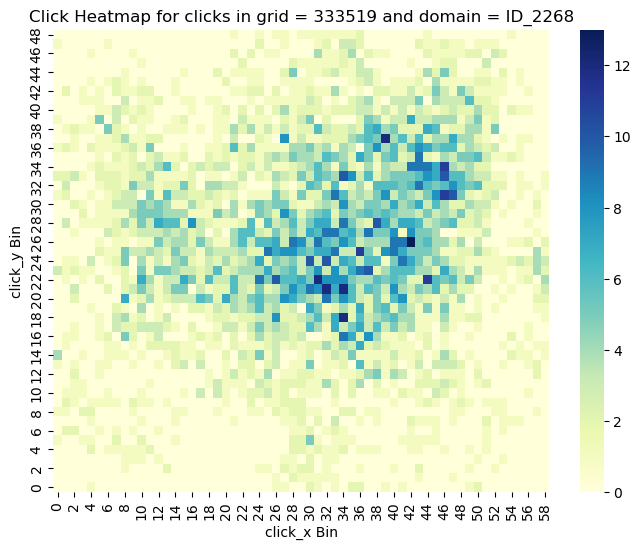

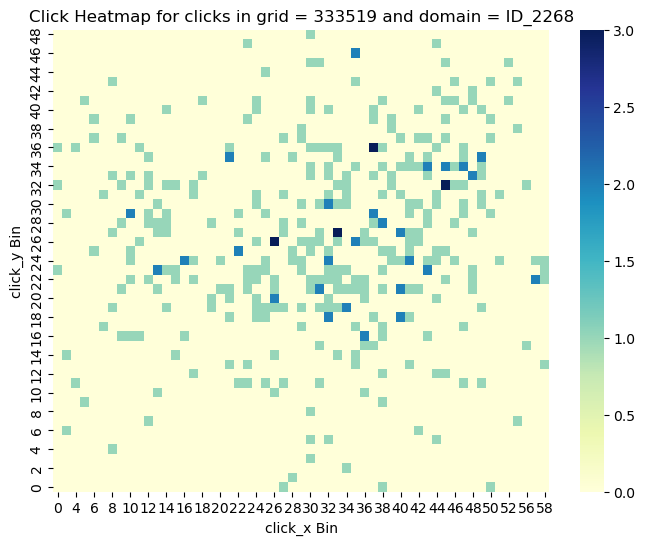

In [18]:
# example

GRID_ID = 333519
ID = 'ID_2268'

data_obs = aggregated_clicks[(aggregated_clicks.grid_id == GRID_ID) &
                             (aggregated_clicks.domain == ID)]

data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()


ex = enhance_data_with_noise(data_obs, 'proba', 5000, 2)

click_matrix = ex.pivot("click_y_bin","click_x_bin", "clicks_sum").fillna(0)

plt.figure(figsize=(8, 6))

sns.heatmap(click_matrix, 
            cmap = "YlGnBu", 
            annot = False, 
            cbar = True, 
            fmt = "g")

plt.title(f'Click Heatmap for clicks in grid = {GRID_ID} and domain = {ID}')
plt.xlabel('click_x Bin')
plt.ylabel('click_y Bin')
plt.gca().invert_yaxis() 
#plt.savefig(f'hm_{ID}_{GRID_ID}.png', bbox_inches='tight')
plt.show()

ex = data_obs
click_matrix = ex.pivot("click_y_bin","click_x_bin", "clicks_sum").fillna(0)

plt.figure(figsize=(8, 6))

sns.heatmap(click_matrix, 
            cmap = "YlGnBu", 
            annot = False, 
            cbar = True, 
            fmt = "g")

plt.title(f'Click Heatmap for clicks in grid = {GRID_ID} and domain = {ID}')
plt.xlabel('click_x Bin')
plt.ylabel('click_y Bin')
plt.gca().invert_yaxis() 
#plt.savefig(f'hm_{ID}_{GRID_ID}.png', bbox_inches='tight')
plt.show()

In [19]:
# chi squared test function with noise enhancement:

def Chi_squared_test_enh(aggregated_clicks, aggregated_clicks_by_grid, ID, GRID_ID, samp_size, stdev):
    observed = aggregated_clicks[(aggregated_clicks.grid_id == GRID_ID) &
                                 (aggregated_clicks.domain == ID)]
    
    observed['proba'] = observed['clicks_sum']/observed['clicks_sum'].sum()
    
    observed = enhance_data(observed, 'proba', samp_size, stdev)
    
    click_stat_grid = aggregated_clicks_by_grid[aggregated_clicks_by_grid.grid_id == GRID_ID]
    click_stat_grid = click_stat_grid.copy()
    click_stat_grid['bin_prob'] = click_stat_grid['clicks_sum']/click_stat_grid['clicks_sum'].sum()

    observed_freq = observed.merge(click_stat_grid, 
                                   on=['click_x_bin',
                                       'click_y_bin'], 
                                   how='right').fillna(0)

    observed_freq = observed[['click_x_bin',
                              'click_y_bin',
                              'clicks_sum']].merge(click_stat_grid[['click_x_bin',
                                                    'click_y_bin',
                                                    'bin_prob']], 
                                   on=['click_x_bin',
                                       'click_y_bin'], 
                                   how='right').fillna(0)

    total_observations = observed_freq['clicks_sum'].sum()
    observed_freq['Expected'] = observed_freq['bin_prob'] * total_observations

    chi_square_stat, p_value = chisquare(f_obs = observed_freq['clicks_sum'], 
                                         f_exp = observed_freq['Expected'])
    
    return chi_square_stat, p_value, total_observations